# 4.1 损失函数
- 最小二乘
- 极大似然
- 交叉熵

In [1]:
# 最小二乘损失函数
import numpy as np

y1 = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
y2 = [0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
t = [0,0,1,0,0,0,0,0,0,0]

def mean_squared_error(y,t):
    return 0.5*np.sum((y-t)**2)

# list不能减 转化为数组
mean_squared_error(np.array(y1),np.array(t))
# 预测分类为索引2的均方误差为0.09750000000000003
mean_squared_error(np.array(y2),np.array(t))
# 预测分类为索引7的均方误差为0.5975

0.5975

In [2]:
# 交叉熵损失函数
# 信息量与概率成反比，概率越小，变成确定性事件所需信息量更大
# 熵是系统混乱程度的衡量，是系统中信息量的期望值
# 衡量两个系统是否接近，衡量两个系统的熵差是否为0
# 当某个系统为理想状态是，只需衡量交叉熵
# 吉布斯不等式：交叉熵大于熵 （正值）
# 所以交叉熵越小，两个系统越接近
# 所以交叉熵符合损失函数的定义
# 输出的概率越大，损失函数越小

def cross_entropy_error0(y,t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta)) # 对应元素相乘，delta防止概率为0时无法计算

t = [0,0,1,0,0,0,0,0,0,0]
y1 = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
y2 = [0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
cross_entropy_error0(np.array(y1), np.array(t))
cross_entropy_error0(np.array(y2), np.array(t))
# 0.510825457099338
# 2.302584092994546

2.302584092994546

In [3]:
# min-batch学习
import sys,os
sys.path.append(os.pardir)
import numpy as np
from res.mnist import load_mnist

(x_train,t_train),(x_test,t_test) =\
    load_mnist(normalize=True,one_hot_label=True)
print(x_train.shape)
print(t_train.shape)
# 随机抽取10笔观测值
train_size = x_train.shape[0]
batch_size =10
batch_mask = np.random.choice(train_size,batch_size) #从指定样本中，选择随机的样本索引
x_batch = x_train[batch_mask]
t_baych = t_train[batch_mask]
# one-hot编码
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]
    return  -np.sum(t*np.log(y+1e-7))/batch_size

# 标签
# 独热编码对应的交叉熵只有编码为1的元素才会计算，因此只要找出标签对应的输出结果y即可计算交叉熵
def cross_entropy_label(y,t):
    if y.ndim ==1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    
    batch_size = y.shape[0]
    # 必须是按顺序的t，y
    return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size
    # y[np.arange(batch_size),t]  花式索引，返回元组索引的y

(60000, 784)
(60000, 10)


# 4.2 数值微分

In [4]:
#  数值微分
# 1、变化程度取无限小，但是计算机会省略掉一定小数点后面的值, 所以变化程度一般去10^(-4)
# 2、不是某一点的导数，一般去x-h，x+h之间的微分
# 3、不精确所以叫数值微分

def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h)-f(x-h))/(2*h)


def func(x):
    return 0.01*x**2 + 0.1*x

numerical_diff(func,10)


def tangent_line(f, x):
    '''切线'''
    d = numerical_diff(f, x)  # 斜率
    y = f(x) - d*x   # 截距：通过x,f(x)这一点
    return lambda t: d*t + y  # 切线

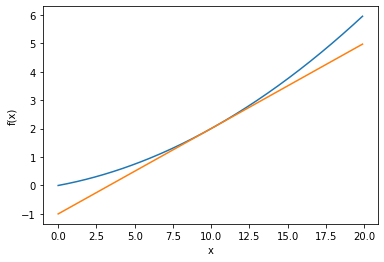

In [5]:
# 可视化
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0,20.0,0.1)
y1 = func(x)
tf = tangent_line(func,10)
y2  = tf(x)
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [6]:
# 偏导数
def func_2(x):
    return np.sum(x**2)
 
def numerical_gradient(f,x):
    '''梯度'''
    h =1e-4
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])   #多维迭代器
    # 不断按行迭代，计算每一行的梯度，直到完成
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val +h
        fxh1 = f(x)
        x[idx] = tmp_val -h
        fxh2 = f(x)
        grad[idx] = (fxh1-fxh2)/(2*h)
        x[idx] = tmp_val
        it.iternext() 
    
    return grad
# 数值微分是通过已知数据不断迭代计算的，不同于理论上的导数，先计算公式，再代入

# 梯度下降法
def gradient_descent(f,init_x,lr=0.01,step_num=1000):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr*grad
    return x

# 测试
numerical_gradient(func_2,np.array([3.0,4.0])) # 浮点数和整数对应的结果相差很大
x = gradient_descent(func_2,np.array([-3.0,4.0]),lr=0.1)
func_2(x)                                             

7.572774547288548e-41

In [7]:
# 以神经网络为例计算梯度
def softmax(x):
    a = np.max(x)
    exp_x = np.exp(x-a)
    exp_sum = np.sum(exp_x)
    y = exp_x/exp_sum
    return y

import numpy as np

class SimpleNet:

    def __init__(self):
        self.W = np.random.randn(2,3)   # 2*3的单层感知机
    
    def predict(self,x):
        return np.dot(x,self.W)
    
    def loss(self,x,t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

# 测试 
net = SimpleNet()
print(net.W)
x = np.array([0.6,0.9])
p = net.predict(x)
print(p)
# np.argmax(p)
t = np.array([0,0,1])
# net.loss(x,t)

# def   f(W):
#     return net.loss(x,t)
# 更简洁的匿名函数
f = lambda W: net.loss(x,t)

print(f(2))
print(f(1))
# W传不进去

dW = numerical_gradient(f,net.W)
print(dW)

# net.W传入后W+h W-h改变
# f(x+h)\f(x)是否会改变呢？
# f 由net.predict(x)计算
# 而predict(x) 由x*self.W计算
# 所以f发生了变化
# 类中包含self.W的方法都可以通过这种方式 传入参数

[[-1.33971792 -0.08248902  2.85359853]
 [-0.15643696  0.28021411 -0.72427945]]
[-0.94462402  0.20269929  1.06030762]
0.44394491745862974
0.44394491745862974
[[ 0.05183434  0.16326524 -0.21509957]
 [ 0.0777515   0.24489786 -0.32264936]]


# 4.3 两层神经网络的学习
-  随机选择min-batch计算损失函数
-  求损失函数的梯度
-  更新参数
-  直到梯度为0或者达到最大步数

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [9]:
# 2层神经网络梯度计算
class TwoLayerNet:

    def __init__(self,input_size,hidden_size,output_size,weight_std=0.01): 
        # 初始化方法，也就是生成类调用的方法
        self.params = {}
        self.params['W1'] = weight_std*np.random.randn(input_size,hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_std*np.random.randn(hidden_size,output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self,x):
        W1,W2 = self.params['W1'],self.params['W2']
        b1,b2 = self.params['b1'],self.params['b2']

        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)

        return  y

    def  loss(self,x,t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)
        accuracy = np.sum(y==t)/float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self,x,t):
        loss_W = lambda W: self.loss(x,t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W,self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W,self.params['W2'])
        grads['b1'] = numerical_gradient(loss_W,self.params['b1'])
        grads['b2'] = numerical_gradient(loss_W,self.params['b2'])

        return grads
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [10]:
net = TwoLayerNet(784,100,10)
net.params['W1'].shape
net.params['b1'].shape
net.params['W2'].shape
net.params['b2'].shape
x = np.random.randn(100,784)
t = np.random.randn(100,10)
y = net.predict(x)
print(y.shape)
grads = net.gradient(x,t)
grads

(100, 10)


{'W2': array([[-7.47241708e-02, -3.81626942e-02,  1.03965366e-01,
         -6.14911627e-02,  5.31480091e-02, -3.02765712e-02,
          2.24250441e-02, -2.08183399e-02, -7.89019434e-02,
         -4.12151082e-02],
        [-8.09127767e-02, -3.65781045e-02,  1.08903251e-01,
         -6.44074184e-02,  6.38776842e-02, -8.73723474e-03,
          2.25990418e-02, -3.56383614e-03, -8.65417040e-02,
         -5.43325436e-02],
        [-6.78742417e-02, -2.89260931e-02,  9.33741332e-02,
         -6.54329862e-02,  5.57242703e-02, -1.56615933e-02,
          2.55828320e-02, -9.19311993e-03, -7.91218592e-02,
         -6.18163644e-02],
        [-8.11720460e-02, -3.82540490e-02,  1.02623469e-01,
         -6.45858287e-02,  6.25660710e-02, -6.09680827e-04,
          1.27849735e-02, -8.98628714e-03, -7.68591275e-02,
         -5.32045046e-02],
        [-6.61779693e-02, -2.25707111e-02,  1.05714106e-01,
         -7.01577779e-02,  5.33938765e-02, -9.97517313e-03,
          1.44560552e-02,  2.84532724e-03, -8.

In [11]:
from res.mnist import load_mnist

(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)
train_loss_list = []
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
network = TwoLayerNet(784,50,10)
# min_batch选择
for i in range(iters_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 梯度
    grad = network.gradient(x_batch,t_batch)
    # 梯度下降
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
    # 记录学习过程
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

# 4.4 神经网络的评价

In [ ]:
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)
train_loss_list = []
train_acc_list = []
test_acc_list = []
# 遍历所有数据集所需min_batch选择次数
iter_per_epoch = max(train_size/batch_size,1)
iters_num = 10000
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(784, 50, 10)
for i in range(iters_num):
    # 获取min_batch
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 梯度
    grad = network.gradient(x_batch,t_batch)
    # 梯度下降
    for  key in ('W1','b1','W2','b2'):
        network.params[key] -= grad[key]*learning_rate
        loss = network.loss(x_batch,t_batch)
        train_loss_list.append(loss)
    # 计算每个epoch的识别精度
    if i%iter_per_epoch==0:
        # 正好遍历完一次样本
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc |" + str(train_acc)+" , "+str(test_acc))

train acc, test acc |0.09736666666666667 , 0.0982
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.10441666666666667 , 0.1028
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135
train acc, test acc |0.11236666666666667 , 0.1135


Text(0, 0.5, 'accuracy')

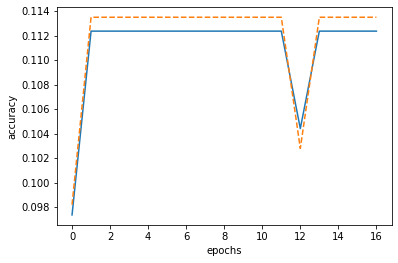

In [ ]:
x = np.arange(len(train_acc_list))
plt.plot(x,train_acc_list,label='train_acc')
plt.plot(x,test_acc_list,label='test_acc',linestyle="--")
plt.xlabel('epochs')
plt.ylabel('accuracy')